# Introduction To Supervised Learning Final Project: Air Quality Prediction 
By David Paradis, for CSCA 5622: Introduction to Machine Learning: Supervised Learning

## Introduction
In this notebook, I will study the correlation between Canadian forest fires, climate, and the effect on air quality by predicting air quality indices (labels).

### Problem Statement
Climate experts indicate that Canada is experiencing a warming rate twice that of the global average, primarily due to its northern geographical position. This accelerated warming has led to a surge in forest fire activity, reaching an unprecedented scale in 2023 with numerous devastating wildfires. 

These fires have significantly contributed to the release of smoke particles into the atmosphere, deteriorating air quality in many major cities across both Canada and the United States. The Air Quality Index (AQI), a tool designed to inform the public about daily air quality levels, has frequently indicated unhealthy conditions, forcing the cancellation of numerous outdoor activities in 2023.

With forecasts suggesting an increase in forest fire activity, it is expected that air quality will continue to worsen during the fire season, which spans from May to October, posing ongoing health risks to populations throughout Canada.

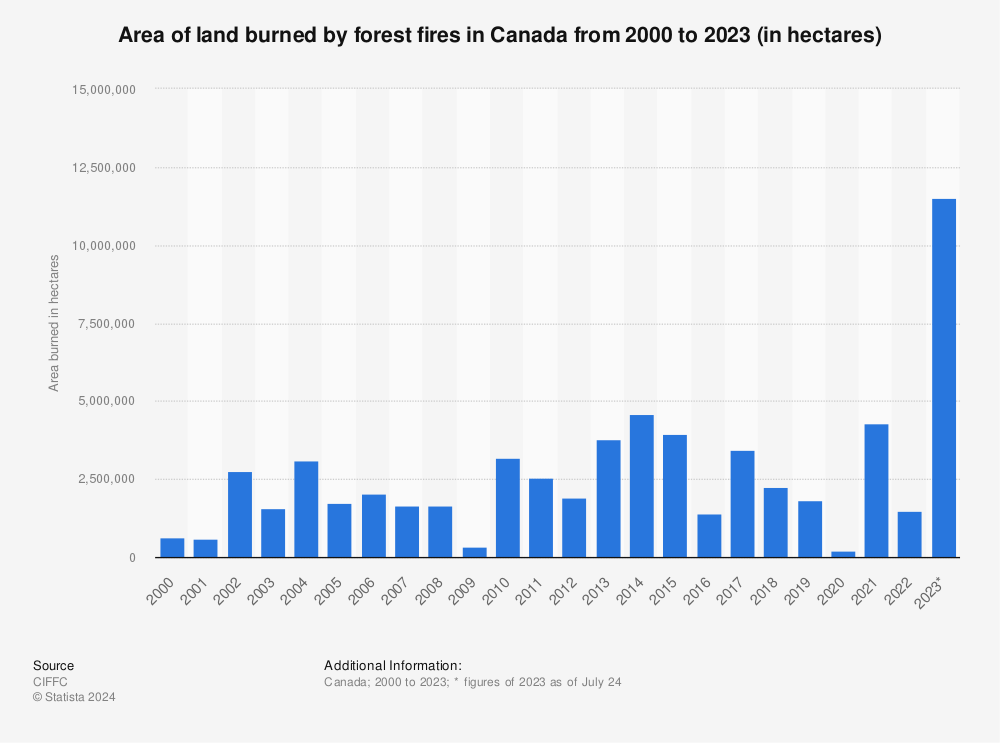

#### Connecting wildfires, global warming and air pollution
Human activities like burning fossil fuels elevate greenhouse gas levels, intensifying climate change and increasing wildfire risks. These elevated temperatures and changing weather patterns make forests more susceptible to fires. Wildfires themselves release harmful pollutants like carbon monoxide and particulate matter, exacerbating air pollution and forming a damaging feedback loop. This cycle of worsening climate conditions and frequent, intense wildfires poses significant risks to both human health and the environment.

#### Smoke particles 





















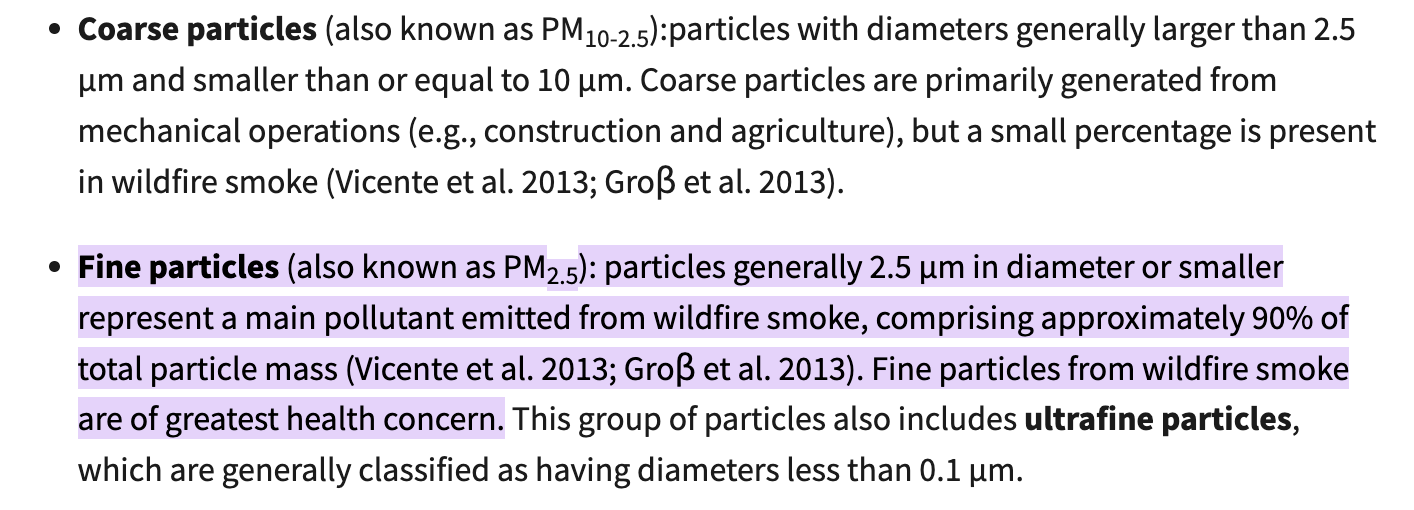


### Objectives
In this study, we will classify whether a given day in a Canadian province is likely to have breathable air, using historical data. This approach allows us to identify patterns in air quality based on past readings, weather data as well as forest fires data. The target value will be the AQI index, from Hazardous to Good, which is a label on a scale that is shown below. 

Numerous scientists have developed models that predict forest fire probabilities based on factors such as location, forest condition, rising temperatures, and decreasing humidity.  This model, while based on historical data, could also be utilized alongside forest fire forecasts to examine potential future impacts on air quality. 



## Data Collection and Description
This study utilizes a combination of three datasets to analyze the impact of wildfire activity on air quality and weather patterns across Canada. The data covers various temporal spans, with specific focus on the year 2023 for weather and air quality metrics, and a broader historical perspective of the last ten years for wildfire occurrences.

### Air Quality Data
Source: OpenAQ platform, which provides real-time air quality information.


Temporal Coverage: Data for the year 2023.

Spatial Coverage: Nationwide, covering all 10 provinces and territories of Canada.

Data Details: Hourly readings of air quality indices such as PM2.5 were averaged to produce a single daily reading per location. This process helps in reducing the noise and focusing on daily trends across different regions.

To collect air quality data from OpenAQ, I've used another notebook that gathered the site information and then queried the API for those sites data for 2023.


[Link to AQ data collection and preprocessing](<AQ data collection.ipynb>)

### Weather Data
Source: Climate Weather Canada's historical data portal.


Temporal Coverage: Data for the year 2023.

Spatial Coverage: Includes comprehensive data from selected weather stations across all provinces and territories. I've selected stations in the most populous and geographically diverse cities for each province, then aggregated the data by province.

Data Details: The dataset includes daily metrics such as temperature, humidity, precipitation, and wind speed. Similar to air quality data, weather readings are averaged by province to simplify the analysis and enhance the clarity of the correlations with wildfire and air quality data.

### Forest Fire Data
Source: Canadian National Fire Database (CNFDB).

Temporal Coverage: Data spanning the last 10 years, providing a historical context to recent trends.

Spatial Coverage: Nationwide

Data Details: Number of forest fires per province per year. No distinction is made between fires that have a burned area of over 200 Ha, for simplicity purpose of gathering this data.



## Exploratory Data Analysis (EDA)



### Library imports


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns



### Data Cleaning


### Air quality data

In [45]:
locations_df = pd.read_csv('canada_aq_locations.csv')
locations_df.head()

,id,name,entity,country,sources,isMobile,isAnalysis,parameters,sensorType,lastUpdated,firstUpdated,measurements,bounds,manufacturers,coordinates.latitude,coordinates.longitude,province
0,953,Pickle Lake,NaN,CA,NaN,False,NaN,"[{'id': 10, 'unit': 'ppm', 'count': 46565, 'av...",NaN,2024-04-21T11:00:00+00:00,2016-03-06T19:00:00+00:00,46565,"[-90.2175, 54.4494, -90.2175, 54.4494]","[{'modelName': 'Government Monitor', 'manufact...",54.449400,-90.217500,ON
1,285,Wagner2,NaN,CA,NaN,False,NaN,"[{'id': 7, 'unit': 'ppm', 'count': 33591, 'ave...",NaN,2024-04-21T11:00:00+00:00,2016-03-10T07:00:00+00:00,67197,"[-114.449722, 53.493889, -114.449722, 53.493889]","[{'modelName': 'Government Monitor', 'manufact...",53.493889,-114.449722,AB
2,287,St. Lina,NaN,CA,NaN,False,NaN,"[{'id': 9, 'unit': 'ppm', 'count': 17146, 'ave...",NaN,2024-04-21T11:00:00+00:00,2016-03-10T07:00:00+00:00,69668,"[-111.50264, 54.216473, -111.50264, 54.216473]","[{'modelName': 'Government Monitor', 'manufact...",54.216473,-111.502640,AB
3,297,Steeper,NaN,CA,NaN,False,NaN,"[{'id': 7, 'unit': 'ppm', 'count': 31206, 'ave...",NaN,2024-04-21T11:00:00+00:00,2016-03-10T07:00:00+00:00,127847,"[-117.09111, 53.1325, -117.09111, 53.1325]","[{'modelName': 'Government Monitor', 'manufact...",53.132500,-117.091110,AB
4,7975,Vanderhoof Courthous,NaN,CA,NaN,False,NaN,"[{'id': 1, 'unit': 'µg/m³', 'count': 9064, 'av...",NaN,2024-04-21T11:00:00+00:00,2018-10-04T21:00:00+00:00,17852,"[-124.0061, 54.0163, -124.0061, 54.0163]","[{'modelName': 'Government Monitor', 'manufact...",54.016300,-124.006100,BC


In [46]:
# Make an average pm25 count per location per day to have a baseline and reduce row count
aq_historical = pd.read_csv('openaq_historical_data.csv')

# Merge with locations to add province column 
locations_df['locationId'] = locations_df['id']
aq_historical = pd.merge(aq_historical, locations_df[['locationId', 'province']], how='left', on='locationId')

aq_historical.head()


,locationId,location,parameter,value,date,unit,coordinates,country,city,isMobile,isAnalysis,entity,sensorType,province
0,297,Steeper,pm25,0.2,"{'utc': '2023-12-31T00:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB
1,297,Steeper,pm25,0.2,"{'utc': '2023-12-30T23:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB
2,297,Steeper,pm25,0.2,"{'utc': '2023-12-30T22:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB
3,297,Steeper,pm25,0.2,"{'utc': '2023-12-30T21:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB
4,297,Steeper,pm25,0.2,"{'utc': '2023-12-30T20:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB


In [47]:
# Convert date 
def extract_and_convert_utc(date_dict):
    utc_str = date_dict['utc']
    return pd.to_datetime(utc_str)

def convert_to_dict(str):
    str = str.replace("'", '"')
    return json.loads(str)

# Convert date field to dict 
aq_historical['date'] = aq_historical['date'].apply(convert_to_dict)
# Apply the function to the 'date' column to get the UTC datetime
aq_historical['datetime'] = aq_historical['date'].apply(extract_and_convert_utc)

# Extract date from datetime
aq_historical['date'] = aq_historical['datetime'].dt.date

aq_historical.head()

,locationId,location,parameter,value,date,unit,coordinates,country,city,isMobile,isAnalysis,entity,sensorType,province,datetime
0,297,Steeper,pm25,0.2,2023-12-31,µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB,2023-12-31 00:00:00+00:00
1,297,Steeper,pm25,0.2,2023-12-30,µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB,2023-12-30 23:00:00+00:00
2,297,Steeper,pm25,0.2,2023-12-30,µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB,2023-12-30 22:00:00+00:00
3,297,Steeper,pm25,0.2,2023-12-30,µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB,2023-12-30 21:00:00+00:00
4,297,Steeper,pm25,0.2,2023-12-30,µg/m³,"{'latitude': 53.1325, 'longitude': -117.09111}",CA,NaN,False,NaN,Governmental Organization,reference grade,AB,2023-12-30 20:00:00+00:00


In [48]:
# Clean up, group data and get mean value for day
grouped_data = aq_historical.groupby([
    'locationId', 'location', 'date', 'parameter', 'province'
]).agg({'value': 'mean'}).reset_index()


grouped_data['date'] = pd.to_datetime(grouped_data['date'])

grouped_data['month'] = pd.to_datetime(grouped_data['date']).dt.month
grouped_data['day_of_month'] = pd.to_datetime(grouped_data['date']).dt.day


grouped_data.head()


,locationId,location,date,parameter,province,value,month,day_of_month
0,287,St. Lina,2023-01-01,pm25,AB,24.491304,1,1
1,287,St. Lina,2023-01-02,pm25,AB,6.675000,1,2
2,287,St. Lina,2023-01-03,pm25,AB,5.678261,1,3
3,287,St. Lina,2023-01-04,pm25,AB,5.627273,1,4
4,287,St. Lina,2023-01-05,pm25,AB,10.283333,1,5


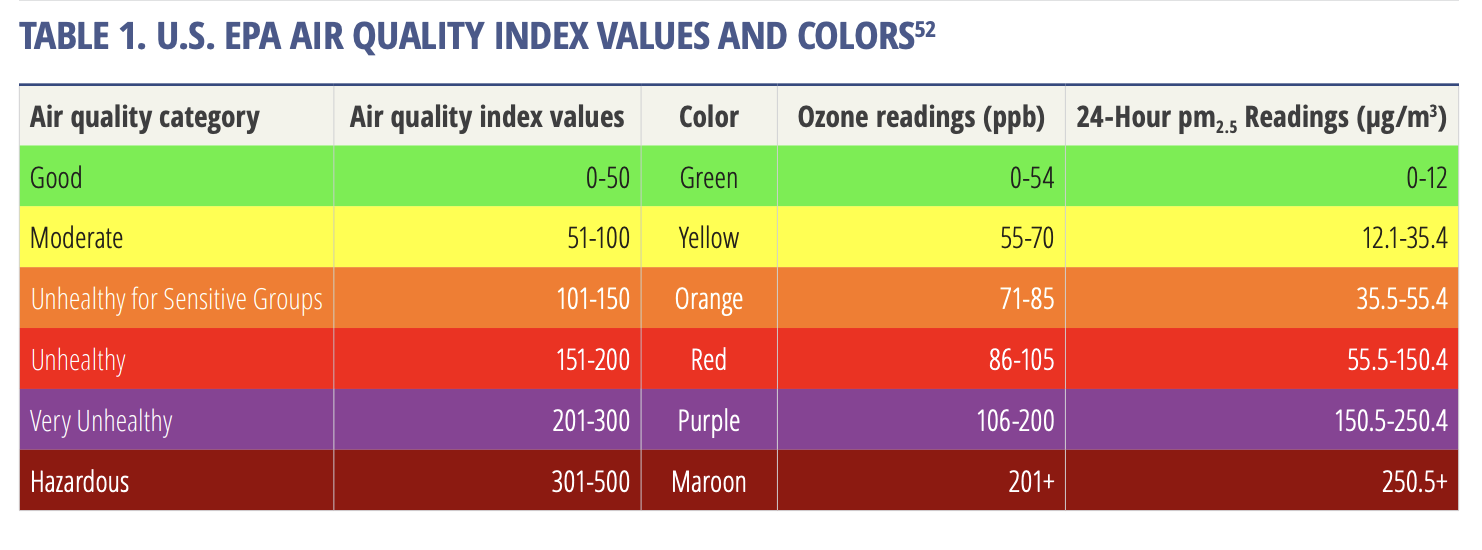

In [49]:
# Apply scale to generate true labels 
def generate_label(pm25_value):
    if pm25_value <= 12.0:
        return 'Good'
    elif pm25_value <= 35.4:
        return 'Moderate'
    elif pm25_value <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif pm25_value <= 150.4:
        return 'Unhealthy'
    elif pm25_value <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'
    
grouped_data['air_quality_label'] = grouped_data['value'].apply(generate_label)

# Optional: Convert air quality labels from categorical to numerical if needed
# This step is optional and depends on your specific needs
quality_mapping = {'Good': 1, 'Moderate': 2, 'Unhealthy for Sensitive Groups': 3, 'Unhealthy': 4, 'Very Unhealthy': 5, 'Hazardous': 6}
grouped_data['air_quality_numerical'] = grouped_data['air_quality_label'].map(quality_mapping)

air_quality_df = grouped_data
air_quality_df.head()

,locationId,location,date,parameter,province,value,month,day_of_month,air_quality_label,air_quality_numerical
0,287,St. Lina,2023-01-01,pm25,AB,24.491304,1,1,Moderate,2
1,287,St. Lina,2023-01-02,pm25,AB,6.675000,1,2,Good,1
2,287,St. Lina,2023-01-03,pm25,AB,5.678261,1,3,Good,1
3,287,St. Lina,2023-01-04,pm25,AB,5.627273,1,4,Good,1
4,287,St. Lina,2023-01-05,pm25,AB,10.283333,1,5,Good,1


In [50]:
# Add average values for baseline
average_pm25_df = pd.read_csv('complete_pm25_data.csv')

average_pm25_df.head()

merged_df = pd.merge(air_quality_df, average_pm25_df[['id', 'pm25_average']], left_on='locationId', right_on='id', how='left')

# Drop the extra 'id' column as it is redundant
merged_df.drop('id', axis=1, inplace=True)


# Calculate the mean pm25 value for each province
province_means = merged_df.groupby('province')['pm25_average'].transform('mean')

# Now, fill NaN values in 'average_pm25' with their province's mean
merged_df['pm25_average'] = merged_df['pm25_average'].fillna(province_means)

# Calculate distance to average
merged_df['pm25_distance_to_average'] = merged_df['value'] - merged_df['pm25_average'] 

air_quality_df = merged_df
air_quality_df.sample(25)

,locationId,location,date,parameter,province,value,month,day_of_month,air_quality_label,air_quality_numerical,pm25_average,pm25_distance_to_average
43882,8867,Sudbury,2023-06-18,pm25,ON,20.125000,6,18,Moderate,2,5.378036,14.746964
24374,1138,Houston Firehall,2023-08-08,pm25,BC,3.379167,8,8,Good,1,11.686010,-8.306843
8939,491,Qu�bec - Vieux-Limoi,2023-03-30,pm25,QC,4.591667,3,30,Good,1,7.526511,-2.934844
28297,1506,Belleville,2023-05-26,pm25,ON,4.750000,5,26,Good,1,6.099971,-1.349971
47646,236027,Auclair,2023-06-21,pm25,QC,4.800000,6,21,Good,1,3.883310,0.916690
40680,8695,Marystown/Burin,2023-10-10,pm25,NL,1.629167,10,10,Good,1,4.556462,-2.927296
2359,390,RED DEER RIVERSIDE D,2023-09-15,pm25,AB,28.366667,9,15,Moderate,2,7.200242,21.166425
44729,230086,Kitimat Haul Road,2023-06-03,pm25,BC,5.916667,6,3,Good,1,3.622010,2.294657
44126,8867,Sudbury,2024-02-17,pm25,ON,2.869565,2,17,Good,1,5.378036,-2.508471
3803,447,Saint-Hilaire-de-Dor,2023-04-11,pm25,QC,10.095833,4,11,Good,1,4.550745,5.545089


### Climate data
The goal is to generate provincial weather average for each day, and add to the air quality data

In [51]:
climate_df = pd.read_csv('climate-daily.csv')


# Ensure the date column is a datetime type
climate_df['LOCAL_DATE'] = pd.to_datetime(climate_df['LOCAL_DATE'])

# Extract year and month from the date for grouping
climate_df['YEAR'] = climate_df['LOCAL_DATE'].dt.year
climate_df['MONTH'] = climate_df['LOCAL_DATE'].dt.month
climate_df['DAY_OF_MONTH'] = climate_df['LOCAL_DATE'].dt.day
climate_df = climate_df[climate_df['YEAR'] == 2023]
# Select relevant features
relevant_data = climate_df[['PROVINCE_CODE', 'YEAR', 'MONTH', 'DAY_OF_MONTH', 'MAX_TEMPERATURE', 'MIN_TEMPERATURE', 
                      'MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY', 'TOTAL_PRECIPITATION', 
                      'SPEED_MAX_GUST']]

print(relevant_data['PROVINCE_CODE'].unique())

# Calculate averages and sums by province, year, and month
daily_aggregates = relevant_data.groupby(['PROVINCE_CODE', 'YEAR', 'MONTH', 'DAY_OF_MONTH']).agg({
    'MAX_TEMPERATURE': 'mean',  # Average of maximum temperatures
    'MIN_TEMPERATURE': 'mean',  # Average of minimum temperatures
    'MAX_REL_HUMIDITY': 'mean',  # Average of maximum relative humidity
    'MIN_REL_HUMIDITY': 'mean',  # Average of minimum relative humidity
    'TOTAL_PRECIPITATION': 'sum',  # Total precipitation
    'SPEED_MAX_GUST': 'mean'  # Average of maximum wind gust speeds
}).reset_index()

daily_aggregates.sample(25)


['AB' 'BC' 'MB' 'NB' 'NL' 'NS' 'NT' 'NU' 'ON' 'PE' 'QC' 'SK' 'YT']


,PROVINCE_CODE,YEAR,MONTH,DAY_OF_MONTH,MAX_TEMPERATURE,MIN_TEMPERATURE,MAX_REL_HUMIDITY,MIN_REL_HUMIDITY,TOTAL_PRECIPITATION,SPEED_MAX_GUST
1485,NL,2023,1,27,7.50,-2.00,98.0,71.0,11.4,90.0
206,AB,2023,7,26,19.45,7.95,91.0,52.0,8.4,49.0
3865,QC,2023,8,5,23.95,14.10,93.5,50.0,0.0,34.0
1112,NB,2023,1,18,1.00,-1.10,96.0,87.0,0.0,37.0
92,AB,2023,4,3,2.95,-4.55,93.5,51.0,0.0,NaN
1037,MB,2023,11,4,1.30,-7.40,92.0,76.0,0.0,NaN
1021,MB,2023,10,19,17.10,5.90,100.0,58.0,0.0,NaN
354,AB,2023,12,21,6.10,-4.95,93.0,55.0,0.0,40.0
1033,MB,2023,10,31,-4.40,-11.70,93.0,64.0,0.0,34.0
4670,YT,2023,10,19,7.50,-1.70,92.0,79.0,0.0,31.0


### Forest fire data
Data is not easily available, but we do have access to the number of forest fires per province for the year 2023, as well as a 10 year average.

In [52]:
fire_data = pd.read_csv('fires_by_province.csv')

fire_data.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)


fire_data = pd.melt(fire_data, id_vars=['Year'], var_name='province', value_name='nb_fires')
fire_data['province'] = fire_data['province'].str.strip()  # Ensure matching province names

# Split data into separate frames for each year type to facilitate specific merging
fires_current = fire_data[fire_data['Year'] == '23'].drop(columns=['Year']).rename(columns={'nb_fires': 'nb_fires'})
fires_avg = fire_data[fire_data['Year'] == '10-yr avg'].drop(columns=['Year']).rename(columns={'nb_fires': 'nb_fires_average'})

print(fires_avg)
# Merge these frames on the 'province' to unify current and average fire data
fires_data = pd.merge(fires_current, fires_avg, on='province', how='outer')



   province  nb_fires_average
1        BC              1392
3        YT               116
5        AB              1181
7        NT               197
9        SK               399
11       MB               342
13       ON               675
15       QC               458
17       NL                96
19       NB               246
21       NS               172
23       PE                 6
25    Total              5380


### Data Visualization


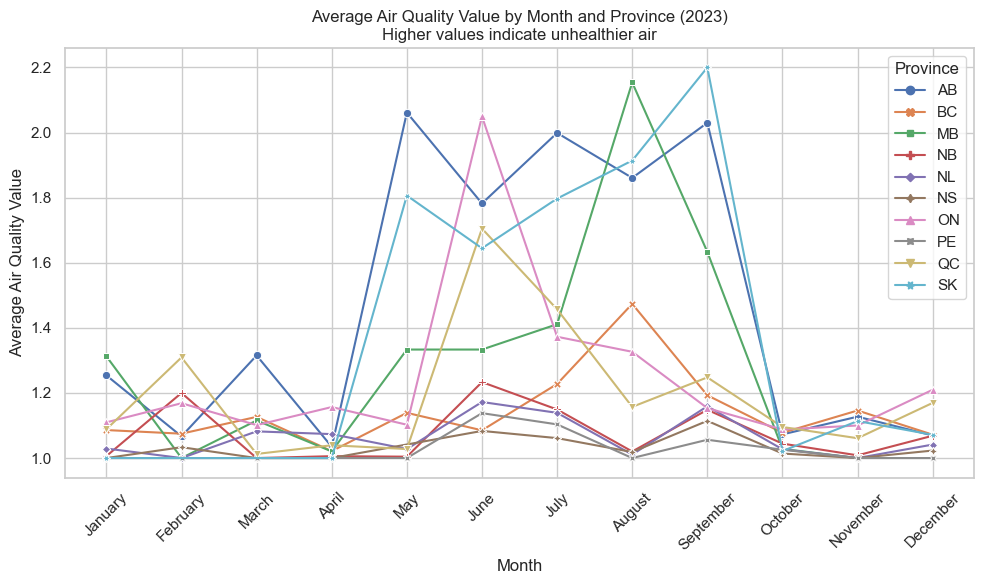

In [53]:
# Filter data for 2023 only
filtered_df = air_quality_df[(air_quality_df['date'] >= '2023-01-01') & (air_quality_df['date'] <= '2024-01-01')]

filtered_df = filtered_df.sort_values('date')



# Aggregate by province and month
filtered_df = filtered_df.groupby(['province', 'month']).agg({'air_quality_numerical': 'mean'}).reset_index()

# Pivot the table for the plot
df_pivot = filtered_df.pivot("month", "province", "air_quality_numerical")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pivot, markers=True, dashes=False)
plt.title('Average Air Quality Value by Month and Province (2023)\nHigher values indicate unhealthier air')
plt.xlabel('Month')
plt.ylabel('Average Air Quality Value')
plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.legend(title='Province')
plt.tight_layout()
plt.show()

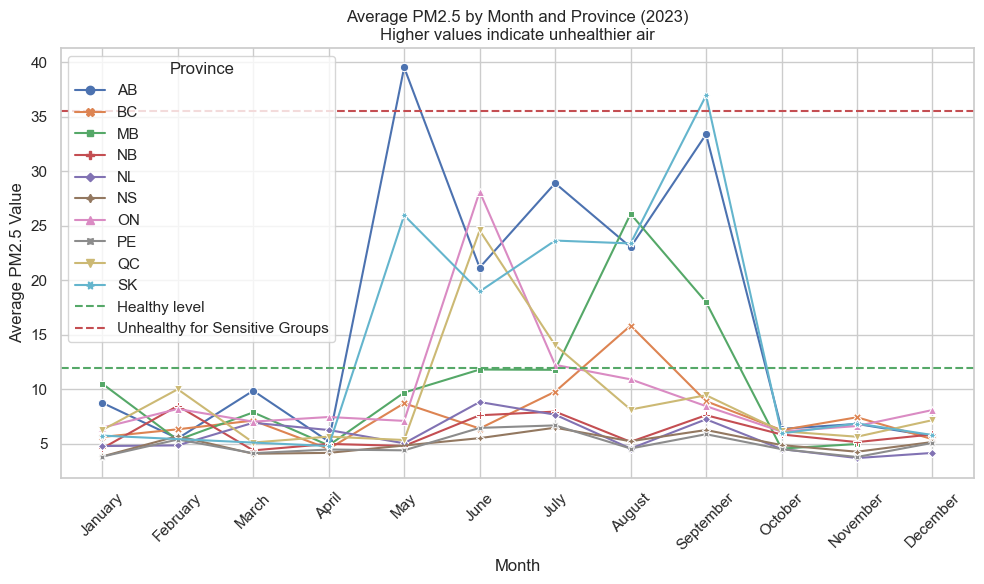

In [54]:
# Plot the average pm25 level for baseline by province and month
filtered_df = air_quality_df[(air_quality_df['date'] >= '2023-01-01') & (air_quality_df['date'] <= '2024-01-01')]

filtered_df = filtered_df.groupby(['province', 'month']).agg({'value': 'mean'}).reset_index()

# Pivot the table for the plot
df_pivot = filtered_df.pivot("month", "province", "value")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pivot, markers=True, dashes=False)
plt.title('Average PM2.5 by Month and Province (2023)\nHigher values indicate unhealthier air')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 Value')
plt.axhline(y=12, color='g', linestyle='--', label='Healthy level')

plt.axhline(y=35.5, color='r', linestyle='--', label='Unhealthy for Sensitive Groups')
plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.legend(title='Province')
plt.tight_layout()
plt.show()

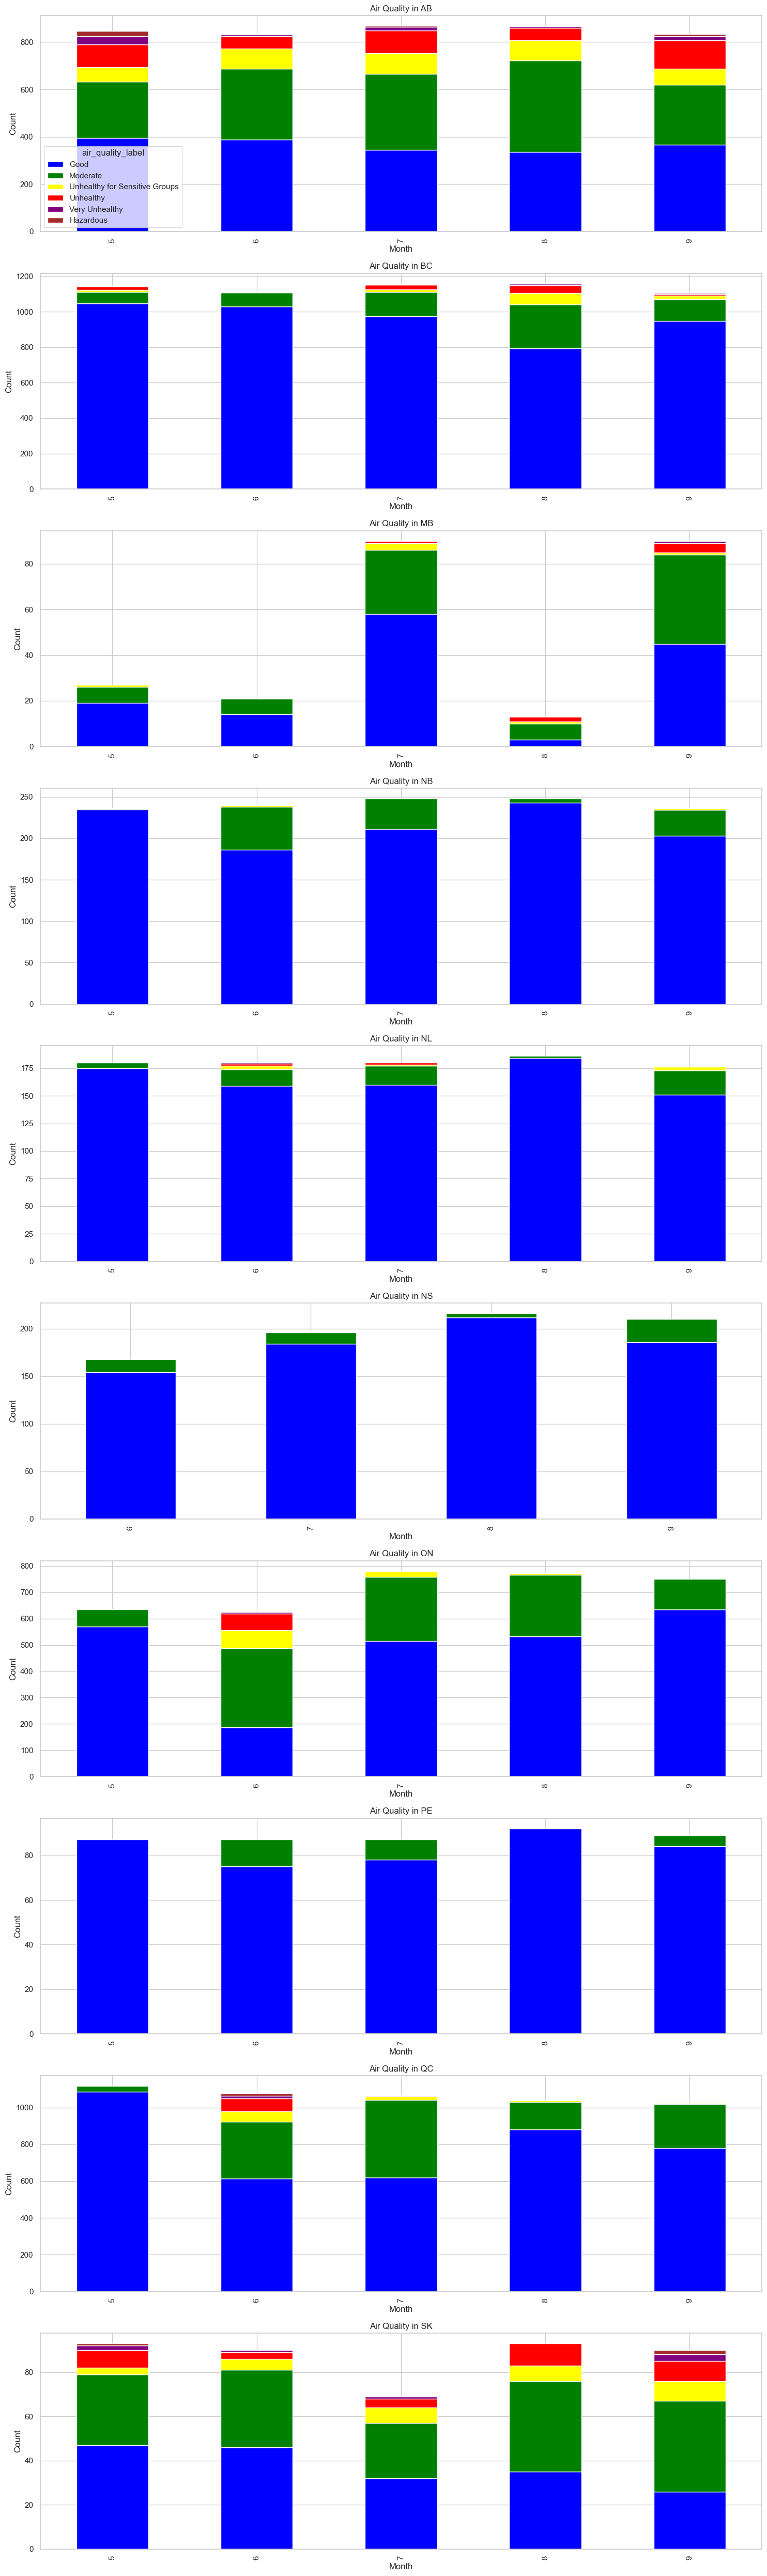

In [55]:
# Plot bar chart for labels from May to October
filtered_df = air_quality_df[(air_quality_df['date'] >= '2023-05-01') & (air_quality_df['date'] < '2023-10-01')]

# Group and aggregate data
grouped_df = filtered_df.groupby(['province', 'month', 'air_quality_label']).size()

# Use unstack to pivot the last level of the index to columns, fill missing values with 0
pivot_df = grouped_df.unstack(level=-1, fill_value=0)

# Reset index to make 'province' and 'month' regular columns for easier plotting
pivot_df.reset_index(inplace=True)

# Define the order of air quality labels from best to worst
# This is just an example, modify it according to your actual labels and desired order
labels_order = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
color_map = {
    'Good': 'blue',
    'Moderate': 'green',
    'Unhealthy for Sensitive Groups': 'yellow',
    'Unhealthy': 'red',
    'Very Unhealthy': 'purple',
    'Hazardous': 'brown'
}
# Filter to include only the columns that exist in your DataFrame to avoid KeyErrors
columns_order = [label for label in color_map.keys() if label in pivot_df.columns]

# Reorder the DataFrame columns according to this order
pivot_df = pivot_df[['province', 'month'] + columns_order]  # Include other necessary columns like 'province' and 'month'

# Plot each province's data in a separate subplot
unique_provinces = pivot_df['province'].unique()

# Create figure with appropriate size
plt.figure(figsize=(15, 5 * len(unique_provinces)))

for i, province in enumerate(unique_provinces, 1):
    ax = plt.subplot(len(unique_provinces), 1, i)
    # Filter data for the current province
    province_data = pivot_df[pivot_df['province'] == province]
    colors = [color_map[label] for label in province_data.columns[2:] if label in color_map]

    # Plot as a bar chart
    province_data.plot(kind='bar', x='month', stacked=True, ax=ax, legend=(i == 1), color=colors)
    
    ax.set_title(f'Air Quality in {province}')
    ax.set_ylabel('Count')
    ax.set_xlabel('Month')

plt.tight_layout()
plt.show()

Demonstrate that 2023 was warmer than usual across Canada.

['AB' 'BC' 'MB' 'NB' 'NL' 'NS' 'NT' 'NU' 'ON' 'PE' 'QC' 'SK' 'YT']


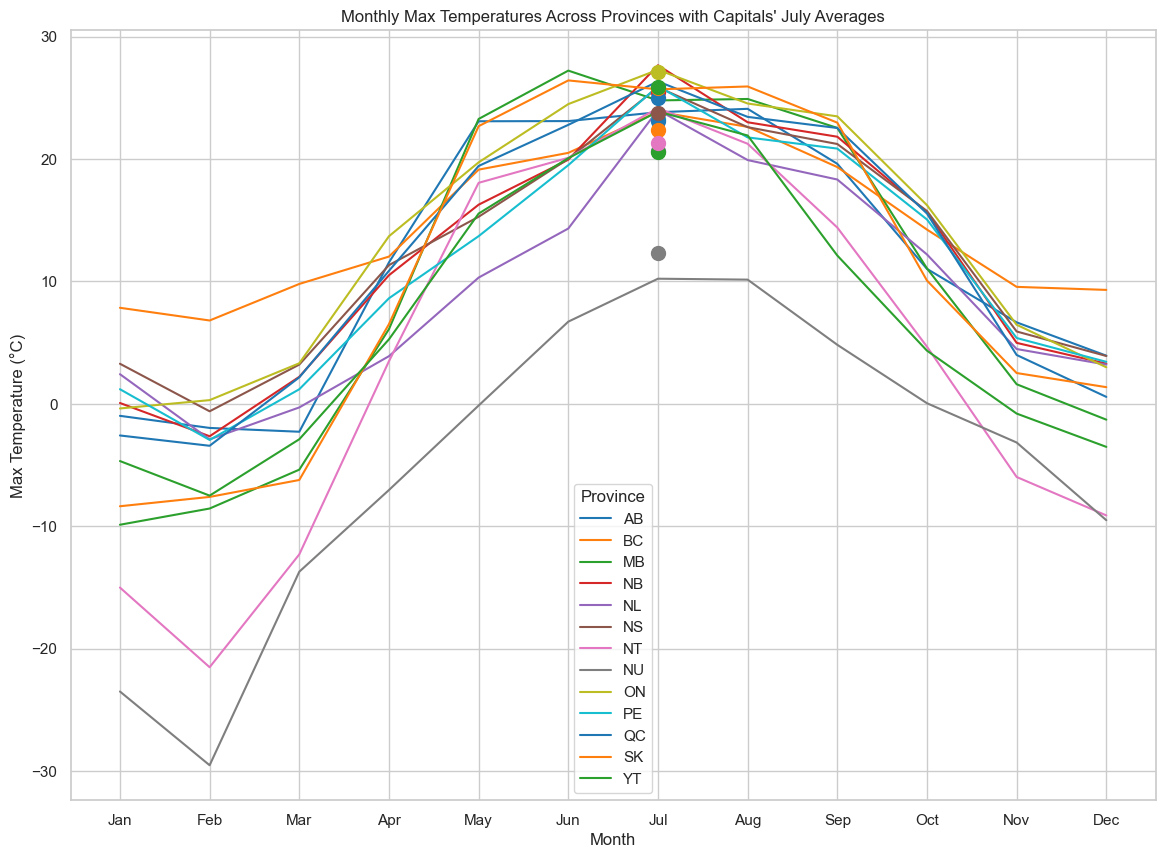

In [56]:
# Plot weather trends by province by month
pivot_data = climate_df.pivot_table(index='PROVINCE_CODE', columns='MONTH', values='MAX_TEMPERATURE', aggfunc='mean')
province_codes = daily_aggregates['PROVINCE_CODE'].unique()
print(province_codes)
# Convert the 'Community' in 'july_highs' to province codes to match 'pivot_data'
province_mapping = {
    'Charlottetown, PE': 'PE',
    'Edmonton, AB': 'AB',
    'Fredericton, NB': 'NB',
    'Halifax, NS': 'NS',
    'Iqaluit, NU': 'NU',
    'Quebec City, QC': 'QC',
    'Regina, SK': 'SK',
    'St. John\'s, NL': 'NL',
    'Toronto, ON': 'ON',
    'Victoria, BC': 'BC',
    'Whitehorse, YT': 'YT',
    'Winnipeg, MB': 'MB',
    'Yellowknife, NT': 'NT'
}

# Data handpicked from Climate Weather Canada 
data = {
    'Community': ['Charlottetown, PE', 'Edmonton, AB', 'Fredericton, NB', 'Halifax, NS', 'Iqaluit, NU',
                  'Quebec City, QC', 'Regina, SK', 'St. John\'s, NL', 'Toronto, ON', 'Victoria, BC',
                  'Whitehorse, YT', 'Winnipeg, MB', 'Yellowknife, NT'],
    'July_Avg_High_C': [23.3, 23.1, 25.5, 23.8, 12.3, 25.0, 25.8, 20.7, 27.1, 22.4, 20.6, 25.9, 21.3]
}

# Create DataFrame
july_highs = pd.DataFrame(data)

july_highs['PROVINCE_CODE'] = july_highs['Community'].map(province_mapping)

palette = sns.color_palette("tab10", n_colors=len(pivot_data.index))

# Map each province to a specific color
color_map = {province: color for province, color in zip(pivot_data.index, palette)}

# Set the plot size
plt.figure(figsize=(14, 10))

# Plotting each province's monthly data
for province in pivot_data.index:
    sns.lineplot(data=pivot_data.loc[province], label=province, color=color_map[province])

# Add July average high temperatures for each capital using the same color map
for index, row in july_highs.iterrows():
    province_code = row['PROVINCE_CODE']
    july_temp = row['July_Avg_High_C']
    if province_code in color_map:
        plt.scatter(7, july_temp, color=color_map[province_code], s=100, zorder=5)  # Month 'July' is the 7th month

plt.title('Monthly Max Temperatures Across Provinces with Capitals\' July Averages')
plt.xlabel('Month')
plt.ylabel('Max Temperature (°C)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Province')
plt.grid(True)

plt.show()

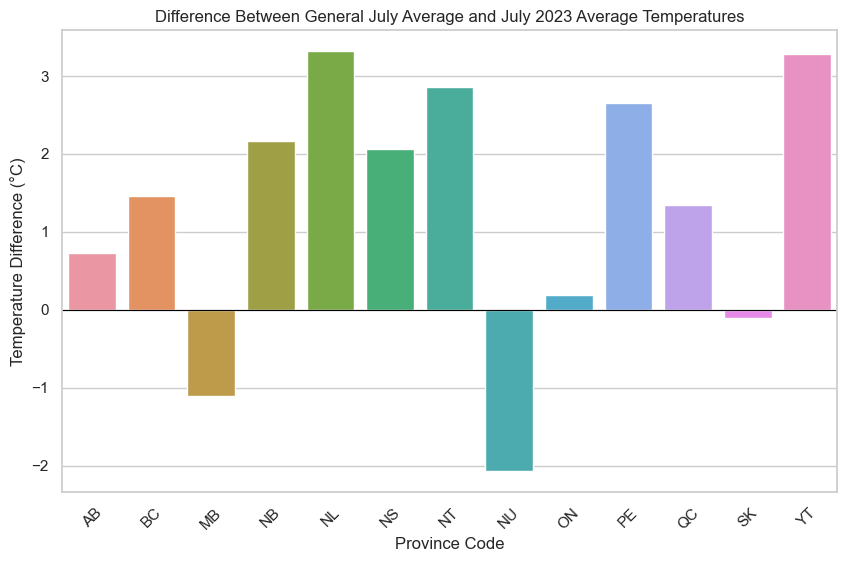

In [57]:
# Filter the data for July 2023
july_2023_data = climate_df[(climate_df['MONTH'] == 7) & (climate_df['YEAR'] == 2023)]

# Calculate the average max temperature for July 2023 by province
july_2023_averages = july_2023_data.groupby('PROVINCE_CODE')['MAX_TEMPERATURE'].mean()

# Calculate differences from the general July averages
july_highs.set_index('PROVINCE_CODE', inplace=True)
differences = july_2023_averages - july_highs['July_Avg_High_C']

# Reset index for plotting
differences = differences.reset_index()
differences.columns = ['PROVINCE_CODE', 'Temperature_Difference']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='PROVINCE_CODE', y='Temperature_Difference', data=differences)
plt.title('Difference Between General July Average and July 2023 Average Temperatures')
plt.xlabel('Province Code')
plt.ylabel('Temperature Difference (°C)')
plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at zero difference for reference
plt.xticks(rotation=45)

plt.show()

## Model Building and Training
### Choice of Model
For this study, the RandomForestClassifier from scikit-learn was selected as the primary model for predicting outcomes based on our labeled data. This decision was influenced by several factors:

Robustness to Overfitting: Random forests are inherently robust against overfitting, which makes them suitable for our dataset with its complex and potentially noisy features derived from multiple sources (air quality indices, weather data, and wildfire metrics).

Ability to Handle Non-linear Relationships: Given the complex nature of environmental data, where relationships between features may not be linear, the random forest's ability to handle non-linearity without explicit model tuning is a significant advantage.

Feature Importance: This model provides straightforward insights into which features are most influential in predicting outcomes, which is crucial for understanding the impact of different environmental factors on air quality and wildfire occurrences.

Flexibility and Scalability: The model is known for its flexibility in handling various types of data and its scalability, which is beneficial for analyzing datasets that could expand in future studies.

### Configuration of the Model
The RandomForestClassifier was configured with specific hyperparameters tailored to optimize performance for our dataset:

n_estimators: Set to 100, indicating the model will use 100 trees. Increasing the number of trees can lead to better performance but requires more computational power and time.

max_depth: Set to None, allowing the trees to expand until all leaves are pure or contain less than min_samples_split samples.

min_samples_split: Set to 2, the smallest number to split a node. Smaller values prevent the model from generalizing well, while larger values might lead to underfitting.

max_features: Set to 'auto', which uses the square root of the number of features at each split, providing a good balance between prediction accuracy and model complexity.

### Model Training
The model was trained using a training dataset comprising 70% of the total data, with the remaining 30% reserved for testing and validation. This split ensures that the model is tested on unseen data, providing a fair assessment of its predictive power.

### Model Validation
Validation was conducted through k-fold cross-validation (with k=10), providing a robust estimate of the model's performance across different subsets of the data. This method helps in identifying any potential issues with model stability and generalizability.


### Preprocessing



In [58]:
from sklearn.preprocessing import OneHotEncoder

# Feature engineering
preprocessed_data = air_quality_df
preprocessed_data['date'] = pd.to_datetime(air_quality_df['date'])
# Keep only fire season 2023
preprocessed_data = preprocessed_data[(preprocessed_data['date'] >= '2023-05-01') & (preprocessed_data['date'] < '2023-10-01')]

weather_df = climate_df
weather_df['date'] = pd.to_datetime(weather_df['YEAR'].astype(str) + '-' + weather_df['MONTH'].astype(str) + '-' + weather_df['DAY_OF_MONTH'].astype(str))

# Rename the 'PROVINCE_CODE' in weather_df to 'province' for a consistent merge key
weather_df.rename(columns={'PROVINCE_CODE': 'province'}, inplace=True)

# Merge air quality measurements and weather readings averages
merged_df = pd.merge(preprocessed_data, weather_df, how='left', on=['date', 'province'])
# Merge fire data
merged_df = pd.merge(merged_df, fires_data, on='province', how='left')

final_df = merged_df[['date', 'day_of_month', 'month', 'air_quality_numerical', 
                        'MAX_TEMPERATURE', 'MIN_REL_HUMIDITY', 'province', 'pm25_distance_to_average',
                        'nb_fires', 'nb_fires_average']]

# Encode province code using one hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(final_df[['province']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(['province']))
final_df = pd.concat([final_df, encoded_df], axis=1)
final_df.drop(['province'], axis=1, inplace=True)

final_df.set_index('date', inplace=True)

# Interpolate missing values using the time method
final_df.interpolate(method='time', inplace=True)

final_df.sample(20)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,day_of_month,month,air_quality_numerical,MAX_TEMPERATURE,MIN_REL_HUMIDITY,pm25_distance_to_average,nb_fires,nb_fires_average,province_AB,province_BC,province_MB,province_NB,province_NL,province_NS,province_ON,province_PE,province_QC,province_SK
date,,,,,,,,,,,,,,,,,,
2023-06-30,30,6,1,22.0,53.0,-1.759420,2217,1392,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-26,26,8,2,23.4,56.0,18.468463,2217,1392,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-12,12,6,2,29.6,38.0,9.423048,690,458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-06-04,4,6,1,23.0,24.0,-3.225395,731,675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-07-17,17,7,3,22.1,60.0,35.719100,952,1181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-28,28,5,1,25.7,24.0,-2.723342,952,1181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-07-31,31,7,1,28.2,19.0,0.695255,952,1181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-13,13,5,1,21.9,53.0,0.358697,2217,1392,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-06,6,5,1,17.9,29.0,1.099195,731,675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


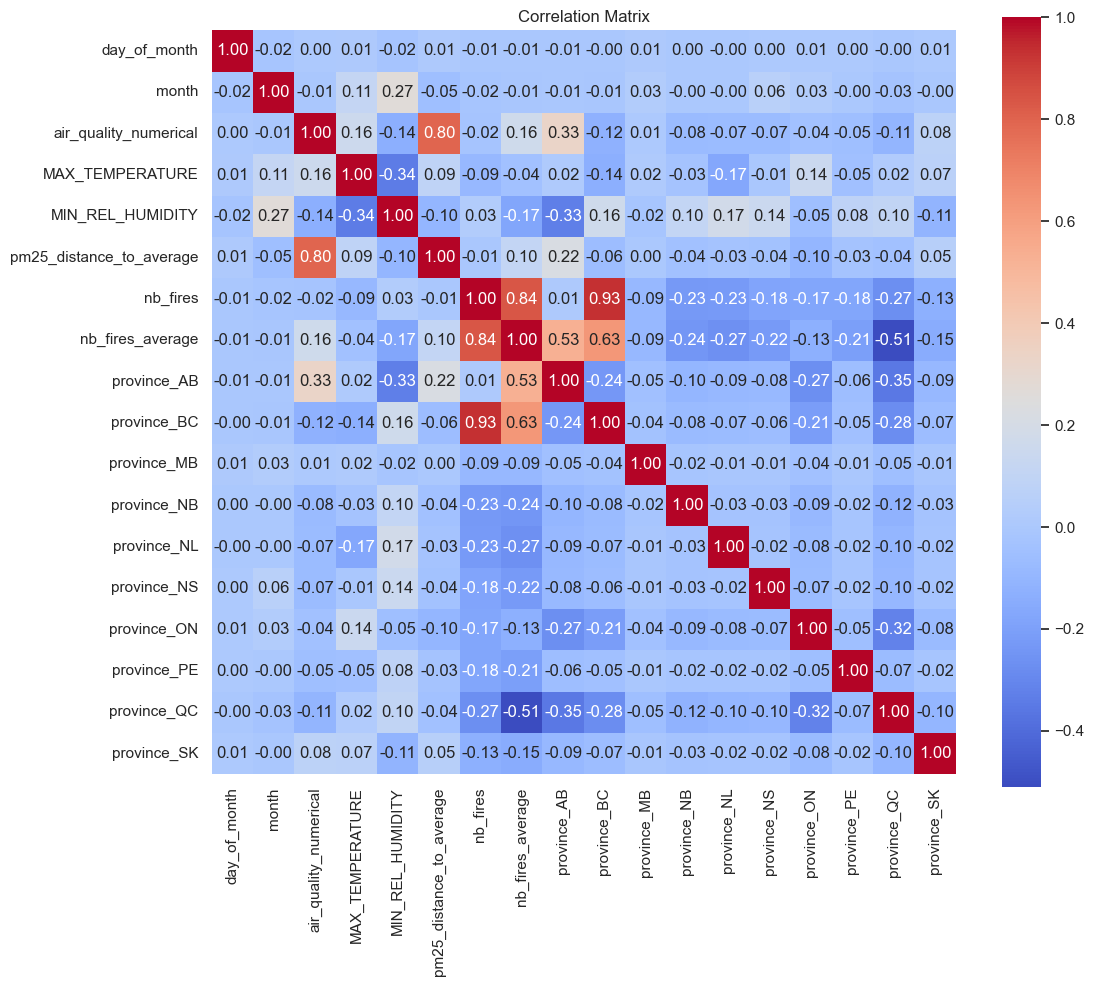

In [59]:
# See if there are correlated features
correlations = final_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()


### Model Training

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data
data = final_df 

X_train, X_test, y_train, y_test = train_test_split(data.drop('air_quality_numerical', axis=1), data['air_quality_numerical'], test_size=0.3, random_state=42)

# Create model
clf = RandomForestClassifier(
    n_estimators=100,    # Number of trees in the forest
    max_depth=None,      # Max depth of each tree. 'None' means nodes are expanded until all leaves are pure or contain less than min_samples_split samples
    min_samples_split=2, # Minimum number of samples required to split an internal node
    max_features='auto', # Number of features to consider when looking for the best split: "auto" means sqrt(n_features)
    random_state=42      # Ensures a deterministic behavior when fitting
)

# Fit the model on the training data
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Results 

Training Accuracy: 1.00
Cross-Validated Scores: [0.93723029 0.94468419 0.93369949 0.9376226  0.92703021 0.9376226
 0.92977638 0.93720565 0.93210361 0.9399529 ]
Mean CV Score: 0.94
Class distribution in training set:
1    0.685291
2    0.233374
3    0.036215
4    0.035391
5    0.006238
6    0.003492
Name: air_quality_numerical, dtype: float64


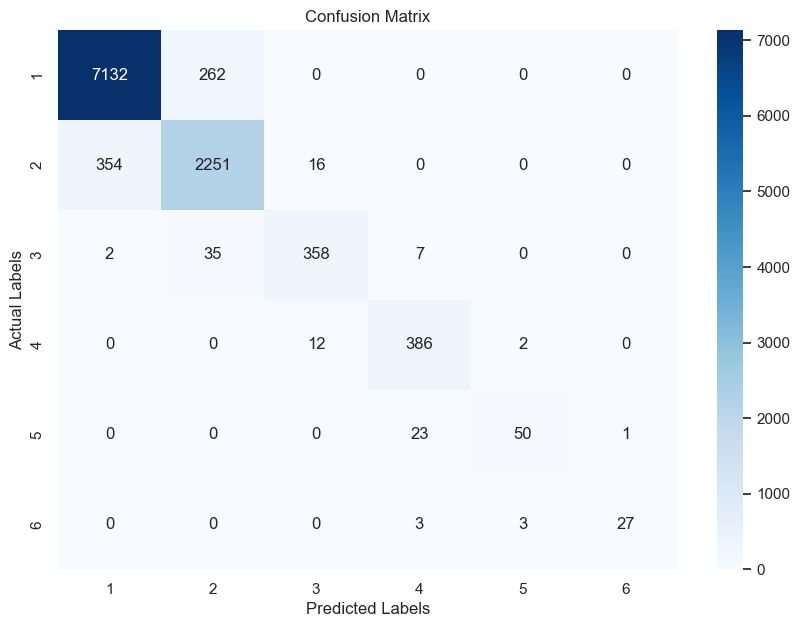

In [61]:

train_preds = clf.predict(X_train)

# Check model performance on the training set
print(f"Training Accuracy: {accuracy_score(y_train, train_preds):.2f}")

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(f"Cross-Validated Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")

# Analyze class distribution
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))

y_pred = clf.predict(X_test)

# Generate the confusion matrix
labels = [1, 2, 3, 4, 5, 6]

cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

We obtain a very good accuracy at around 0.94, with a confusion matrix demonstrating that the model can correctly predict across all 6 labels.

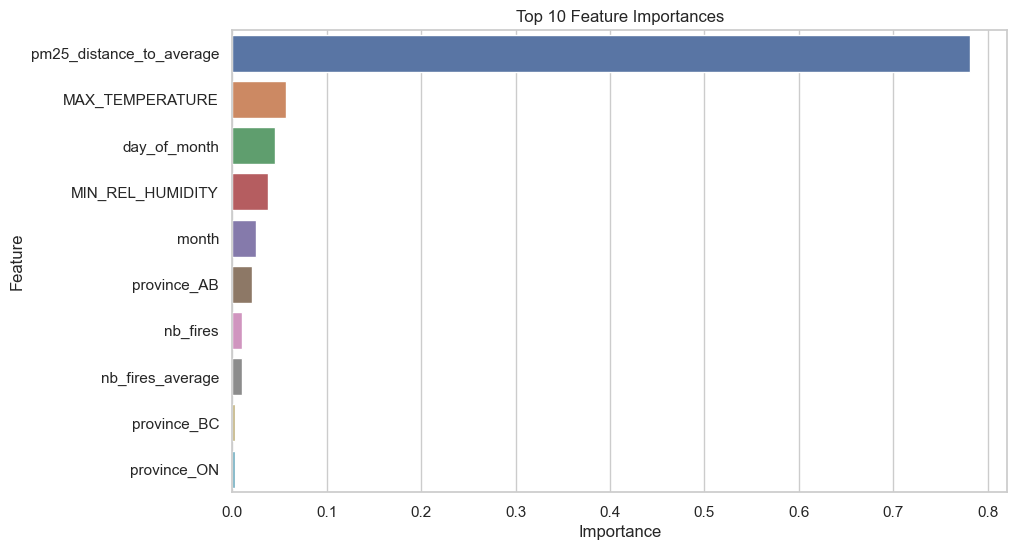

In [62]:
feature_importances = clf.feature_importances_

# Get the feature names from X_test
feature_names = X_test.columns

# Create a DataFrame to hold the feature importances
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame to see the most important features at the top
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plot the feature importances for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances_df.head(10))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


As we can see, the PM2.5 distance to the average contributes very significantly to the model. Therefore, it is safe to conclude that the wildfires have a great incidency on the air quality in a province. It is interesting to note that the maximum temperature as well as the relative humidity also contribute, which is understandable given that fires happen when temperatures are warm and relative humidity low.

### Predict future dates

To test the model, we generate random synthetic data with a relatively pessimistic value. Temperatures are between 18 and 35 degrees Celsius, the PM2.5 distance from the average is between -10 and +35, and the number of fires is between 700 and 1500 which is higher than the past 10 years average. 

In [63]:
# Constants
provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']
months_fire_season = [6, 7, 8, 9]  # June to September
np.random.seed(42)


def generate_random_row():
    # Generate random data
    data = {
        'day_of_month': np.random.randint(1, 30),  # Random day of the month
        'month': np.random.choice(months_fire_season),  # Random month in fire season
        'MAX_TEMPERATURE': np.random.uniform(18, 35),  # Simulate temperature between 18°C and 35°C
        'MIN_REL_HUMIDITY': np.random.uniform(20, 60),  # Simulate humidity between 20% and 60%
        'pm25_distance_to_average': np.random.uniform(-10, 35),  # PM2.5 distance to average
        'nb_fires': np.random.randint(700, 1500),  # Number of fires, simulate a strong season
        'nb_fires_average': np.random.randint(500, 1400)  # Average number of fires
    }

    # Add a column for each province as one-hot encoding
    row_province = np.random.choice(provinces)
    for province in provinces:
        data[f'province_{province}'] = 1 if province == row_province else 0

    return data

# Create DataFrame
future_data = []
for i in range(30): 
    row = generate_random_row()
    future_data.append(row)
future_data_df = pd.DataFrame(future_data)

predicted_labels = clf.predict(future_data_df)
future_data_df['predicted_air_quality'] = predicted_labels

future_data_df.head(30)

,day_of_month,month,MAX_TEMPERATURE,MIN_REL_HUMIDITY,pm25_distance_to_average,nb_fires,nb_fires_average,province_AB,province_BC,province_MB,province_NB,province_NL,province_NS,province_ON,province_PE,province_QC,province_SK,predicted_air_quality
0,7,9,34.162143,49.279758,16.939632,1314,621,0,0,1,0,0,0,0,0,0,0,2
1,23,8,25.807231,33.348344,-3.570993,830,1161,0,0,0,0,1,0,0,0,0,0,1
2,2,9,32.151525,28.493564,-1.817876,976,660,0,0,0,0,0,0,0,0,0,1,1
3,22,6,25.343065,31.649166,17.533380,1381,975,0,0,1,0,0,0,0,0,0,0,2
4,12,8,34.714925,38.670516,28.697318,1346,520,0,0,0,0,0,0,0,0,1,0,2
5,7,7,34.131054,58.625281,26.377881,1476,845,0,0,0,0,1,0,0,0,0,0,2
6,2,9,22.097433,47.330541,17.449850,1475,534,1,0,0,0,0,0,0,0,0,0,2
7,4,7,29.262879,32.468443,13.403061,805,1271,0,0,0,0,0,1,0,0,0,0,2
8,29,8,32.318841,37.990165,7.781761,969,1362,0,0,0,0,0,0,0,1,0,0,2
9,14,8,26.854182,58.446881,28.004023,1448,837,0,0,0,0,1,0,0,0,0,0,3


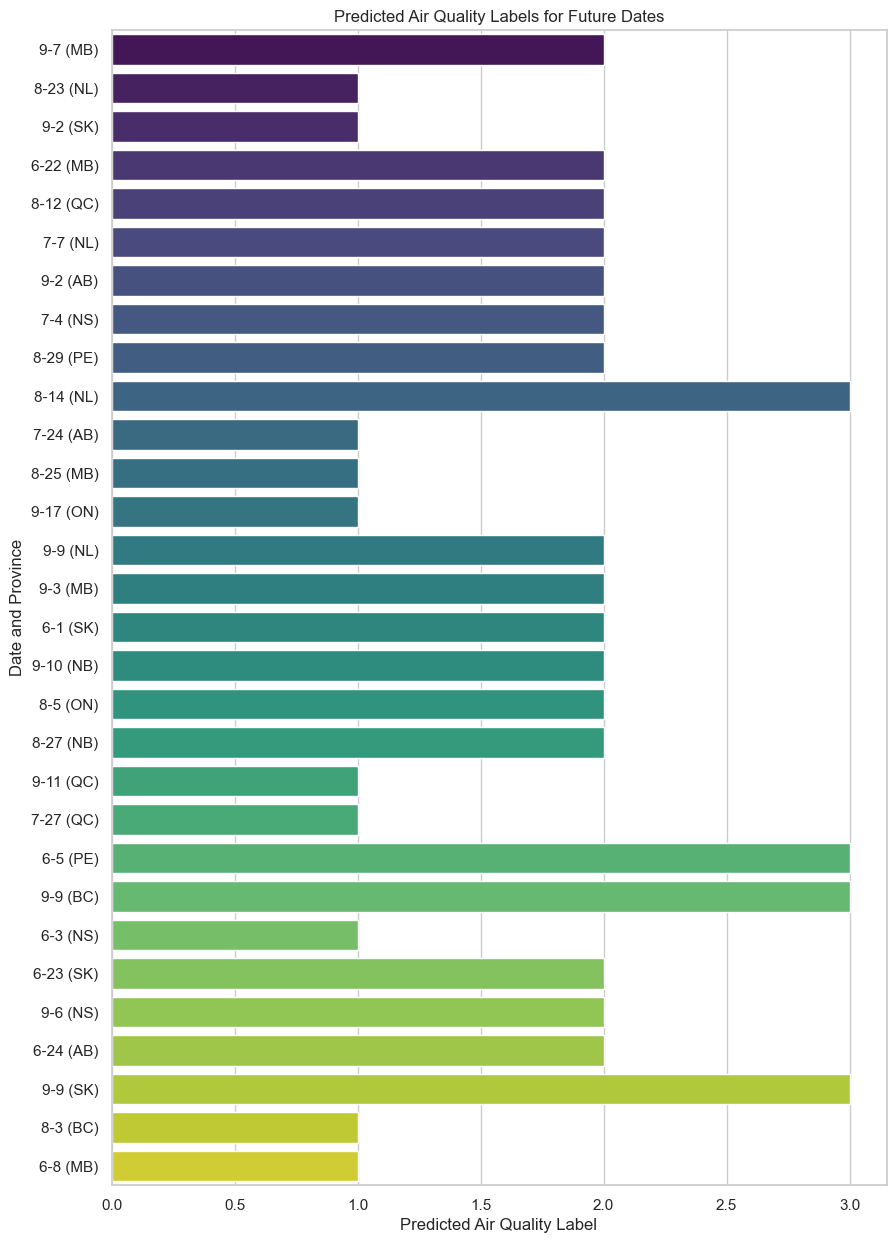

In [64]:
# Create a 'province' column from the one-hot encoded province columns
for province in provinces:
    future_data_df.loc[future_data_df[f'province_{province}'] == 1, 'province'] = province

# Convert 'month' and 'day_of_month' to string before concatenation
future_data_df['date'] = future_data_df['month'].astype(str) + '-' + future_data_df['day_of_month'].astype(str)
future_data_df['date_province'] = future_data_df['date'] + ' (' + future_data_df['province'] + ')'

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a horizontal bar chart
plt.figure(figsize=(10, 15))  # Adjust size as needed for clarity
chart = sns.barplot(y='date_province', x='predicted_air_quality', data=future_data_df, palette='viridis', orient='h')
plt.title('Predicted Air Quality Labels for Future Dates')
plt.ylabel('Date and Province')
plt.xlabel('Predicted Air Quality Label')

# Improve label readability
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.show()

As we can see, the outputted labels globally trend higher, with more Moderate than we normally have, as seen in the class distribution.

## Discussion and Conclusion
By using relatively pessimistic randomized data for the future, we can show that the air quality has a tendency to degrade from Good to Moderate. While it is maybe not alarming, it shows that it is concerning given the implications of global warming and its impact on the wildfires. 

It is important to note that many shortcuts were taken in averaging the data, which do not reflect the vast climate differences across different canadian cities in a same province, as well as the complexity of forest fire patterns and behaviors. A more in-depth look with access to better data might yield different results, although the model seems to be well generalized. 

While this model is very simplistic, it can show that there is a tendency towards degrading air quality as the climate warms up.

### Future Work
For future work, one thing that would be interesting would be to insert more precise geographical data into the model, allowing for better predictions base on location. Another idea would be to use weather data from before the fire season, showing the impact of a warmer spring on the future air quality, for instance. 

## References
[https://www.epa.gov/wildfire-smoke-course/why-wildfire-smoke-health-concern#:~:text=Fine particles](https://www.epa.gov/wildfire-smoke-course/why-wildfire-smoke-health-concern#:~:text=Fine%20particles%20) 

https://cdnsciencepub.com/doi/10.1139/cjfr-2018-0293

https://cwfis.cfs.nrcan.gc.ca/report/graphs

https://natural-resources.canada.ca/climate-change/what-adaptation/10025

https://aqicn.org/scale/

https://www.cleanairfund.org/news-item/wildfires-climate-change-and-air-pollution-a-vicious-cycle/

https://openaq.org/

https://climate.weather.gc.ca/ 

https://cwfis.cfs.nrcan.gc.ca/ha/nfdb

https://publicinterestnetwork.org/wp-content/uploads/2021/10/CA-Trouble-in-the-Air-Web.pdf

https://github.com/david-paradis/air-quality-supervised-ml/
